In [21]:
!pip install pyfits

Defaulting to user installation because normal site-packages is not writeable
  Using cached pyfits-3.5.tar.gz (1.7 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [87 lines of output]
      /usr/lib/python3/dist-packages/setuptools/dist.py:723: UserWarning: Usage of dash-separated 'author-email' will not be supported in future versions. Please use the underscore name 'author_email' instead
        warnings.warn(
      /usr/lib/python3/dist-packages/setuptools/dist.py:723: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      /usr/lib/python3/dist-packages/setuptools/dist.py:723: UserWarning: Usage of dash-separated 'home-page' will not be supported in future versions. Please use the underscore name 'home_page' instead
        warnings.warn(


In [19]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pyfits'

[ 7.98074784e-03  1.00000035e+02  9.99983191e+01 -5.02461660e+01
 -5.02424504e+01]


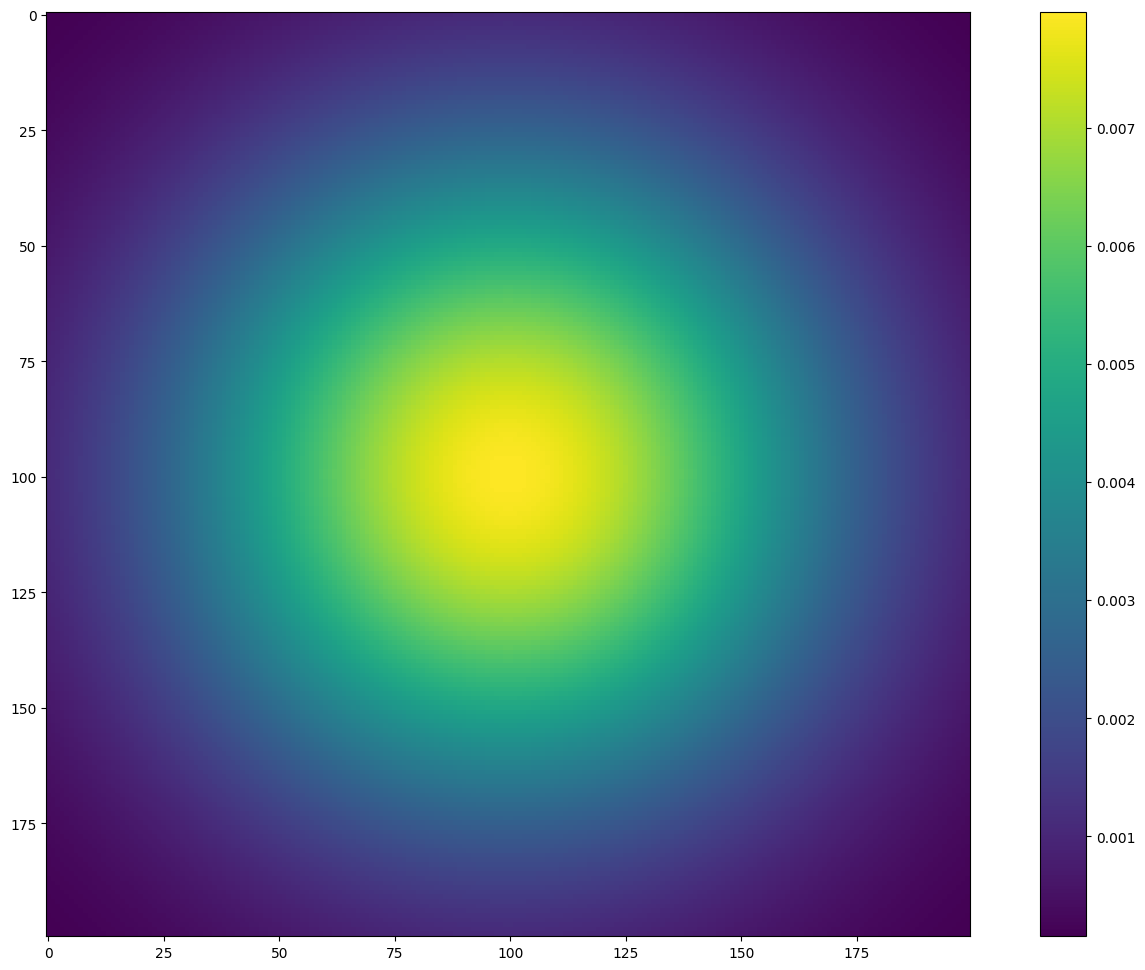

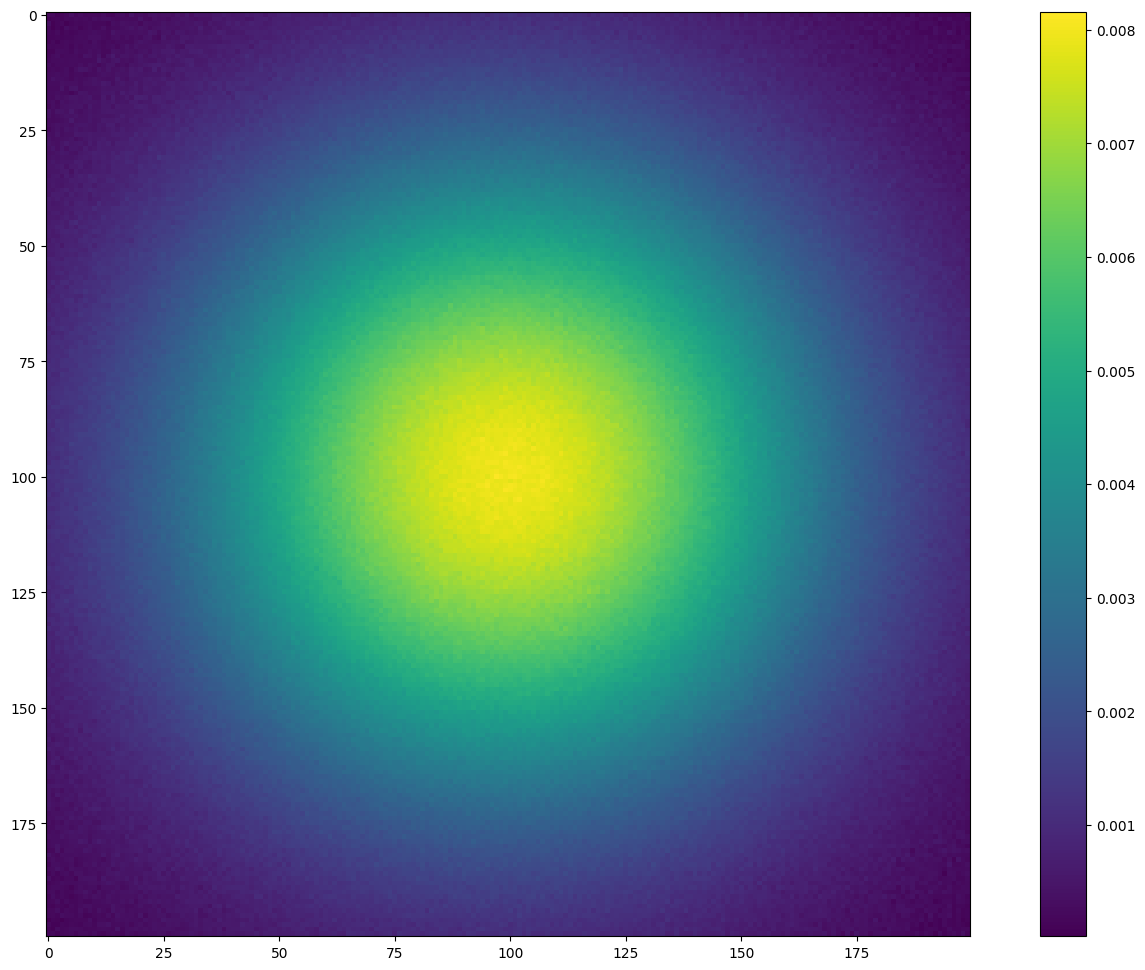

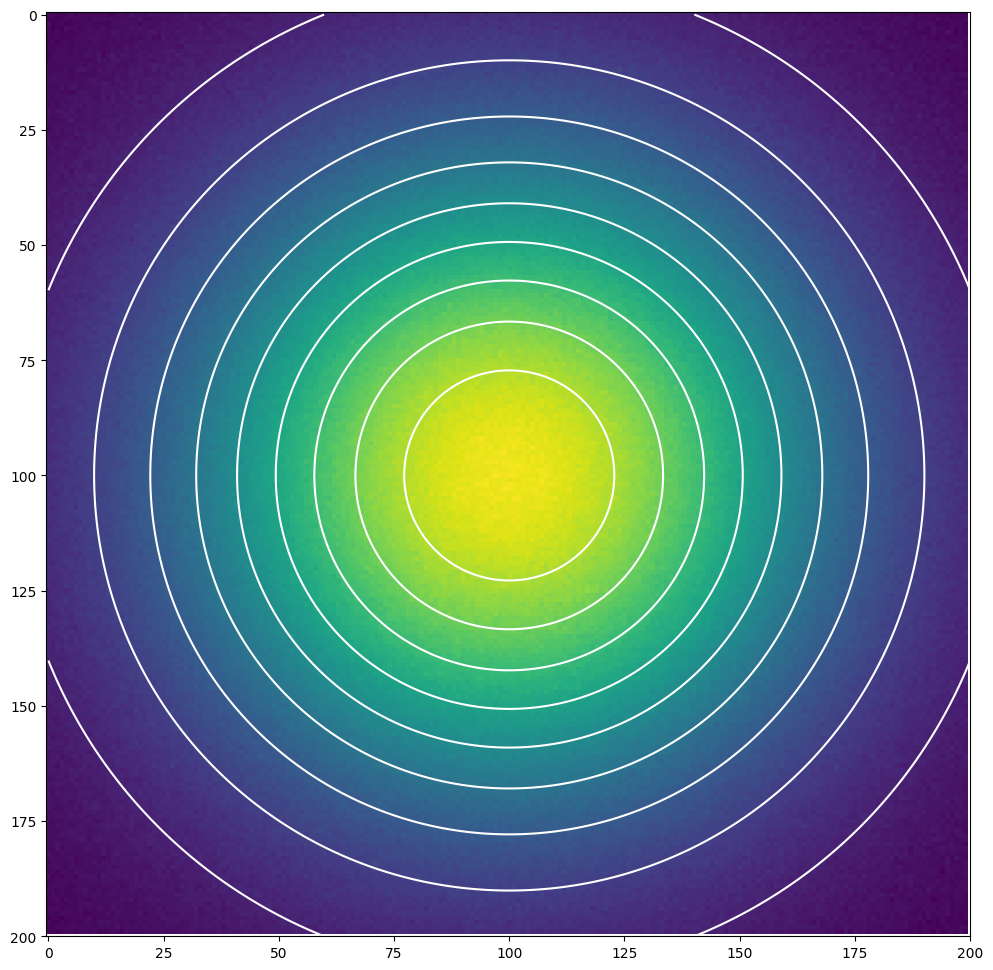

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Let's build a 2D Gaussian grid
i, j = np.indices([200, 200])
center = np.array([(i.max() - i.min()) / 2.0, (j.max() - j.min()) / 2.0])
xc = center[1]
yc = center[0]
r = np.hypot(i - yc, j - xc)
s = 50
Gaussian = (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-r**2 / (2 * s**2))

fig = plt.figure(figsize=(18, 12))
plt.imshow(Gaussian)
plt.colorbar()

# Let's add some noise to it
mean = 0
SNR = 1000
size = 200
sigma = Gaussian.std() / np.sqrt(SNR)
gaussian_noise = np.random.normal(mean, scale=sigma, size=(size, size))
nois_g = Gaussian + gaussian_noise

fig = plt.figure(figsize=(18, 12))
plt.imshow(nois_g)
plt.colorbar()

# Now we define a 2D Gaussian model and fit it to the data we generated
def Gaussian_2d(coords, A, mu_x, mu_y, sigma_x, sigma_y):
    x, y = coords
    G = A * np.exp(-(x - mu_x)**2 / (2 * sigma_x**2) - (y - mu_y)**2 / (2 * sigma_y**2))
    return np.ravel(G)

x = np.linspace(0, 200, 200)
y = np.linspace(0, 200, 200)
x, y = np.meshgrid(x, y)

p0 = np.array([0.05, 30, 50, 30, 10])
popt, pcov = curve_fit(Gaussian_2d, (x, y), np.ravel(nois_g), p0)

print(popt)

fitted_gaussian = Gaussian_2d((x, y), *popt)
fitted_gaussian = fitted_gaussian.reshape(200, 200)  # to reconstruct a 2D array

fig = plt.figure(figsize=(18, 12))
plt.imshow(nois_g)
plt.contour(x, y, fitted_gaussian, 10, colors='w')

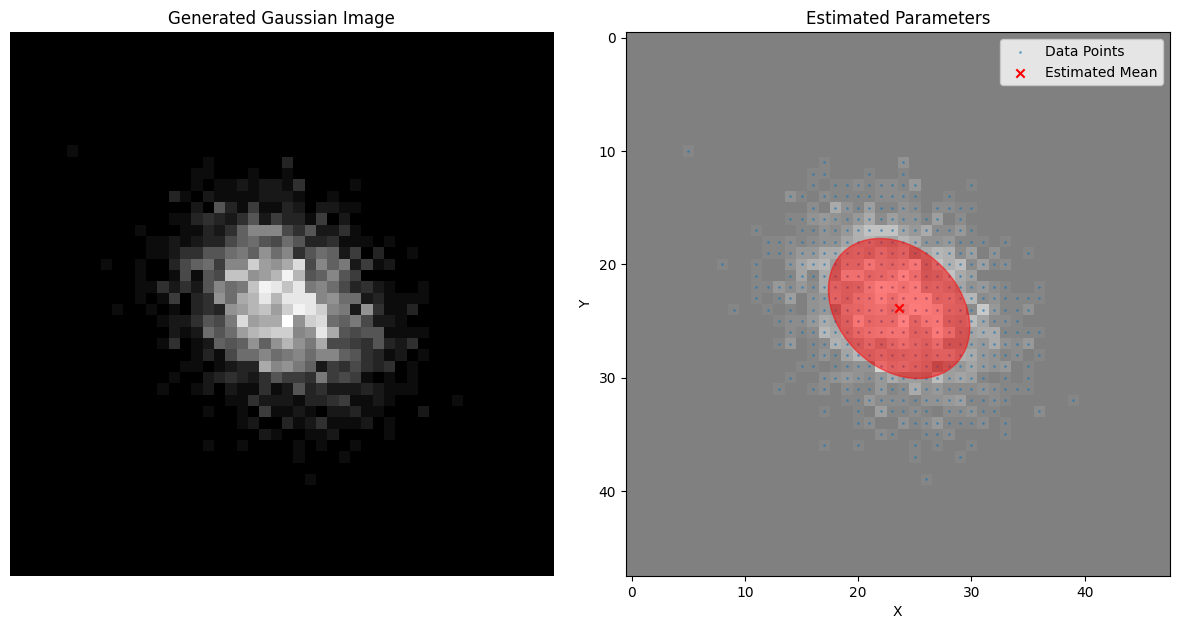

Estimated Mean: [23.61411765 23.90588235]
Estimated Covariance Matrix:
[[38.92149834 10.43529412]
 [10.43529412 38.20338513]]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def generate_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image."""
    num_pixels = size[0] * size[1]
    x = np.random.multivariate_normal(mean, cov, num_pixels)
    x = np.clip(x, 0, size[0] - 1).astype(int)
    image = np.zeros(size, dtype=np.float32)
    for i in range(num_pixels):
        image[x[i, 1], x[i, 0]] += 1
    return image

def estimate_gaussian_parameters(data):
    """Estimate the mean and covariance matrix of 2D Gaussian data."""
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data, rowvar=False)
    return mean, covariance_matrix

def plot_covariance_ellipse(mean, cov, ax, color='blue', label=None):
    """Plot an ellipse representing the covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.5)
    ax.add_patch(ellipse)
    
    if label:
        ax.legend([ellipse], [label])

# Parameters
size = (48, 48)
mean = np.array([24, 24])  # Center of the image
cov = np.array([[20, 5], [5, 20]])  # Example covariance matrix

# Generate synthetic Gaussian image
image = generate_gaussian_image(size, mean, cov)

# Extract pixel coordinates
y_coords, x_coords = np.nonzero(image > 0)  # Use non-zero pixels
data = np.vstack((x_coords, y_coords)).T

# Estimate parameters
estimated_mean, estimated_covariance_matrix = estimate_gaussian_parameters(data)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the generated image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Generated Gaussian Image')
plt.axis('off')

# Plot the estimated Gaussian distribution
ax = plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray', origin='upper', alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data Points', s=1)
plt.scatter(estimated_mean[0], estimated_mean[1], color='red', label='Estimated Mean', marker='x')
plt.title('Estimated Parameters')
plt.xlabel('X')
plt.ylabel('Y')

# Draw the ellipse representing the covariance
plot_covariance_ellipse(estimated_mean, estimated_covariance_matrix, ax, color='red', label='Estimated Covariance')

plt.legend()
plt.tight_layout()
plt.show()

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_covariance_matrix)

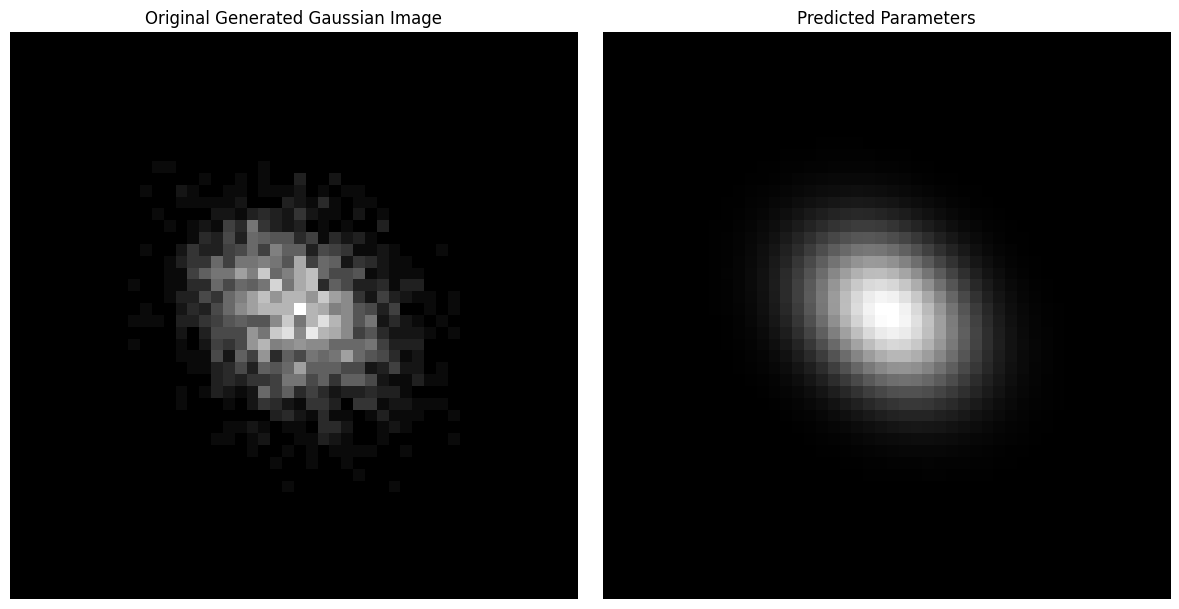

Estimated Mean: [23.56814236 23.41145833]
Estimated Covariance Matrix:
[[20.74796079  5.11692754]
 [ 5.11692754 19.05466037]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter

def generate_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image with noise."""
    num_pixels = size[0] * size[1]
    x = np.random.multivariate_normal(mean, cov, num_pixels)
    x = np.clip(x, 0, size[0] - 1).astype(int)
    image = np.zeros(size, dtype=np.float32)
    for i in range(num_pixels):
        image[x[i, 1], x[i, 0]] += 1
    return image

def generate_ideal_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image without noise based on the mean and covariance."""
    x, y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))
    xy = np.column_stack([x.ravel(), y.ravel()])
    
    inv_cov = np.linalg.inv(cov)
    diff = xy - mean
    z = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
    z = z.reshape(size)
    z /= z.max()  # Normalize to the range [0, 1]
    
    return z

def estimate_gaussian_parameters(data, weights):
    """Estimate the mean and covariance matrix of 2D Gaussian data with weights."""
    # Calculate weighted mean

    # Apply Gaussian smoothing
    sigma = 1.0  # Standard deviation for Gaussian kernel
    smoothed_data = gaussian_filter(data, sigma=sigma)

    # Now smoothed_data contains the noise-smoothed 2D Gaussian
    mean = np.average(data, axis=0, weights=weights)
    
    # Calculate weighted covariance matrix
    diff = data - mean
    covariance_matrix = np.cov(diff.T, aweights=weights, bias=True)
    
    return mean, covariance_matrix

def plot_covariance_ellipse(mean, cov, ax, color='blue', label=None):
    """Plot an ellipse representing the covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.5)
    ax.add_patch(ellipse)
    
    if label:
        ax.legend([ellipse], [label])

# Parameters
size = (48, 48)
mean = np.array([24, 24])  # Center of the image
cov = np.array([[20, 5], [5, 20]])  # Example covariance matrix

# Generate synthetic Gaussian image
image = generate_gaussian_image(size, mean, cov)

# Extract pixel coordinates and their intensity values
y_coords, x_coords = np.indices(size)
data = np.vstack((x_coords.ravel(), y_coords.ravel())).T
weights = image.ravel()

# Estimate parameters
estimated_mean, estimated_covariance_matrix = estimate_gaussian_parameters(data, weights)

# Generate an ideal Gaussian image using the estimated parameters (without noise)
ideal_image = generate_ideal_gaussian_image(size, estimated_mean, estimated_covariance_matrix)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the generated image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Original Generated Gaussian Image')
plt.axis('off')

# Plot the ideal Gaussian distribution image (without noise)
plt.subplot(1, 2, 2)
plt.imshow(ideal_image, cmap='gray', origin='upper')
plt.title('Predicted Parameters')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_covariance_matrix)

True Mean: [24 24]
True Covariance Matrix:
[[20  5]
 [ 5 20]]

Estimated Mean: [23.89285714 23.26785714]
Estimated Covariance Matrix:
[[7.98831169 2.22922078]
 [2.22922078 8.05422078]]
Estimated Angle (degrees): 45.42347058265701


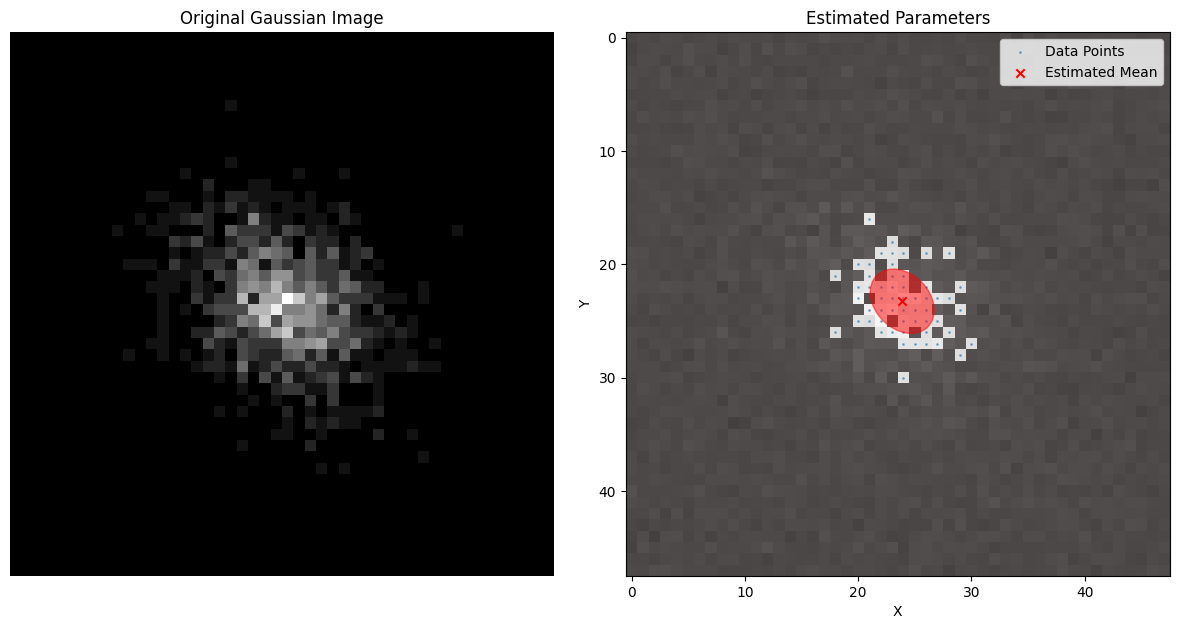

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def generate_gaussian_image(size, mean, cov, num_samples=1000):
    """Generate a 2D Gaussian image with noise."""
    num_pixels = size[0] * size[1]
    x = np.random.multivariate_normal(mean, cov, num_samples)
    x = np.clip(x, 0, size[0] - 1).astype(int)
    image = np.zeros(size, dtype=np.float32)
    for i in range(num_samples):
        image[x[i, 1], x[i, 0]] += 1
    return image

def add_gaussian_noise(image, mean=0, var=0.1):
    """Add Gaussian noise to the image."""
    noise = np.random.normal(mean, np.sqrt(var), image.shape)
    noisy_image = image + noise
    return noisy_image

def threshold_image(image, threshold):
    """Threshold the image to separate signal from noise."""
    return (image > threshold).astype(np.float32)

def estimate_gaussian_parameters(data):
    """Estimate the mean and covariance matrix of 2D Gaussian data."""
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data, rowvar=False)
    return mean, covariance_matrix

def plot_covariance_ellipse(mean, cov, ax, color='blue', label=None):
    """Plot an ellipse representing the covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.5)
    ax.add_patch(ellipse)
    
    if label:
        ax.legend([ellipse], [label])
    
    # Print the angle
    print("Estimated Angle (degrees):", angle)

# Parameters
size = (48, 48)
true_mean = np.array([24, 24])  # Center of the image
true_cov = np.array([[20, 5], [5, 20]])  # Example covariance matrix
num_samples = 1000
noise_var = 0.5  # Variance of Gaussian noise
threshold = 5  # Threshold for noise filtering

# Generate synthetic Gaussian image
image = generate_gaussian_image(size, true_mean, true_cov, num_samples)
noisy_image = add_gaussian_noise(image, var=noise_var)

# Apply thresholding
thresholded_image = threshold_image(noisy_image, threshold)

# Extract pixel coordinates
y_coords, x_coords = np.nonzero(thresholded_image > 0)
data = np.vstack((x_coords, y_coords)).T

# Estimate parameters
estimated_mean, estimated_covariance_matrix = estimate_gaussian_parameters(data)

# Print real and estimated values
print("True Mean:", true_mean)
print("True Covariance Matrix:")
print(true_cov)
print("\nEstimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_covariance_matrix)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the generated image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Original Gaussian Image')
plt.axis('off')

# Plot the noisy image and the thresholded image
plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray', origin='upper', alpha=0.5)
plt.imshow(thresholded_image, cmap='hot', origin='upper', alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data Points', s=1)
plt.scatter(estimated_mean[0], estimated_mean[1], color='red', label='Estimated Mean', marker='x')
plt.title('Estimated Parameters')
plt.xlabel('X')
plt.ylabel('Y')

# Draw the ellipse representing the covariance
plot_covariance_ellipse(estimated_mean, estimated_covariance_matrix, plt.gca(), color='red', label='Estimated Covariance')

plt.legend()
plt.tight_layout()
plt.show()